In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.23.41:35157")
client

Client Scheduler: tcp://10.32.23.41:35157 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 9 Cores: 18 Memory: 103.50 GB


In [2]:
import dask
import dask.array as dsa

In [3]:
from scipy import interpolate
import gsw
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

### Gridded monthly mean Argo data

In [4]:
url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/Argo_Products/monthly_mean/Gridded_monthly_mean'
ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 27, lon: 360, time: 180)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2019-12-15
  * lev      (lev) float64 0.0 5.0 10.0 20.0 ... 1.4e+03 1.5e+03 1.75e+03 2e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Data variables:
    temp     (time, lev, lat, lon) float32 ...
    salt     (time, lev, lat, lon) float32 ...
    ptemp    (time, lev, lat, lon) float32 ...
    pden     (time, lev, lat, lon) float32 ...
    addep    (time, lev, lat, lon) float32 ...
    spice    (time, lev, lat, lon) float32 ...
Attributes:
    title:          1x1 gridded Monthly mean on Standard Levels (from 2005)
    Conventions:    COARDS\nGrADS
    dataType:       Grid
    documentation:  http://apdrc.soest.hawaii.edu/projects/Argo/index.html
    history:        Fri Jul 19 13:26:16 HST 2019 : imported by GrADS Data Ser...

In [14]:
import numpy.ma as ma

In [ ]:
ma.masked_invalid()

In [ ]:
a = pden.where(pden.min(axis=1)<24)

### Function for computing isopycnal depth

In [5]:
def compute_iso(den, iso, z):

    dep_iso = np.zeros((den.shape[1], den.shape[2]))
    dep_iso[:, :] = np.nan
    for i in np.arange(0, den.shape[2], 1):
        for j in np.arange(0, den.shape[1], 1):

            den_tmp = den[:, j, i]

            id1 = np.where(den_tmp < iso)

            if np.size(id1) > 0 and np.size(id1) < len(z):
                
                den1 = den_tmp[id1[0][-1]]
                den2 = den_tmp[id1[0][-1] + 1]

                if den1 < den2:
                    fun2 = interpolate.interp1d([den1, den2], [z[id1[0][-1]], z[id1[0][-1] + 1]])
                    dep_iso[j, i] = fun2(iso)
                    print(str(i) + '  ' + str(j))
                    print('success')

    return dep_iso

In [ ]:
np.arange(0, 10, 1)

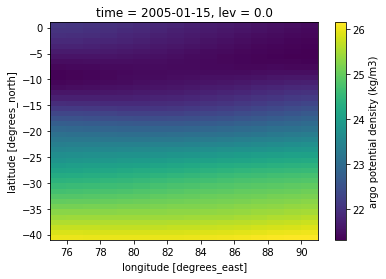

In [12]:
ds.pden[0,0].sel(lon=slice(75.5, 90.5), lat=slice(-40.5, 0.5)).plot()

In [17]:
masked = ma.masked_invalid(a[t, :, :, :].values)
masked

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [21.632999420166016, 21.607999801635742, 21.589000701904297,
          ..., 21.09600067138672, 21.0310001373291, 20.968000411987305],
         [21.722999572753906, 21.690000534057617, 21.658000946044922,
          ..., 20.992000579833984, 20.91699981689453,
          20.844999313354492],
         [21.820999145507812, 21.777000427246094, 21.731000900268555,
          ..., 20.900999069213867, 20.812999725341797,
          20.73200035095215]],

        [[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [21.650999069213867, 21.624000549316406, 21.601999282836914,
          ..., 21.138999938964844, 21.069000244140625,
          20.999000549316406],
         [21.7450008392334, 21.708999633789062, 21.674999237060547, ...,
          21.04199981689453, 20.95

In [18]:
%%time

pden = ds.sel(lon=slice(75.5, 90.5), lat=slice(-40.5, 0.5)).pden#.chunk(chunks={'lat' : 30, 'lon' : 30})
z = pden.lev.values
iso = [24]

a = pden.where(pden.min(axis=1)<24)


size = a.shape
dep_iso = np.zeros((size[0], size[2], size[3]))
for t in np.arange(size[0]):
#for t in np.arange(1):
    data = masked
    dep_iso[t, :, :] = compute_iso(data, iso, z)
    #print(str(pden.time[t].values))
    
ds_dep_iso = xr.DataArray(dep_iso, coords={'time': pden.time, 'lat': pden.lat, 'lon': pden.lon}, dims=['time', 'lat', 'lon'])



/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nputils.py:220: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


0  17
success
0  18
success
0  19
success
0  20
success
0  21
success
0  22
success
0  23
success
0  24
success
0  25
success
0  26
success
0  27
success
0  28
success
0  29
success
0  30
success
0  31
success
0  32
success
0  33
success
0  34
success
0  35
success
0  36
success
0  37
success
0  38
success
0  39
success
0  40
success
0  41
success
1  17
success
1  18
success
1  19
success
1  20
success
1  21
success
1  22
success
1  23
success
1  24
success
1  25
success
1  26
success
1  27
success
1  28
success
1  29
success
1  30
success
1  31
success
1  32
success
1  33
success
1  34
success
1  35
success
1  36
success
1  37
success
1  38
success
1  39
success
1  40
success
1  41
success
2  18
success
2  19
success
2  20
success
2  21
success
2  22
success
2  23
success
2  24
success
2  25
success
2  26
success
2  27
success
2  28
success
2  29
success
2  30
success
2  31
success
2  32
success
2  33
success
2  34
success
2  35
success
2  36
success
2  37
success
2  38
success
2  39


KeyboardInterrupt: 

In [ ]:
ds_dep_iso

In [ ]:
ds_dep_iso[170, :, :].plot(figsize=(10, 8))
plt.contour(pden.lon, pden.lat, ds_dep_iso[170, :, :], colors='k')

In [ ]:
ds_dep_iso[:, 40, 20].plot(figsize=(10, 5))